# Description
This is a jupyter notebook to analyze the data of the PTB-XL database of ECG measurements. To get a general understanding of ECG signals, the following URLs were used:

* https://www.nhs.uk/conditions/electrocardiogram/
* https://geekymedics.com/understanding-an-ecg/


All python files are structured in subfolders. Else this notebook would just be too long (and it allowed to better structure the code).

In [1]:
from utils.loading import load_signal_and_annotations, load_diagnostic_aggregation
from utils.plotting import plot_ecg_signal
from utils.preprocessing import butter_bandpass_filter, smooth_signal, normalize_signal
from utils.ecg_signal_analysis import find_peaks, find_heartbeat_peaks, find_qrs_complex

from model.model_handler import ModelHandler
from model.data_generator import get_cross_validation_split
from train_model import run_crossvalidation_experiment


## Constants
Defining some constants that will be re-used throughout the script

In [2]:
path = './data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 100
channels = ["I", "II", "III", "AVL", "AVR", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]

## Data Loading
We load the data with functions that are based on the script provided in the dataset (´example_physionet.py´).
To get a general overview the size and available information of the loaded dataset is printed.

In [3]:
X, Y = load_signal_and_annotations(sampling_rate, path)
Y = load_diagnostic_aggregation(path, Y)

print('Loaded ECG data files: ' + str(len(X)))
print('Loaded annotation files: ' + str(len(Y['patient_id'])))
print('Available annotation information:')
print(list(Y.columns))

Loaded ECG data files: 21801
Loaded annotation files: 21801
Available annotation information:
['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH', 'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC', 'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL', 'oneshot_labels']


# Signal Plotting for Diagnosis
We plot the signal such that doctors could use it for diagnosis.
The patient id can be specified.
The format in clinics is usually standardized to grids where each square corresponds to 0.2s in width and 0.5 mV in height.
We output the format correspondingly. The Figure has a high resolution so with zoom it can be analyzed better.

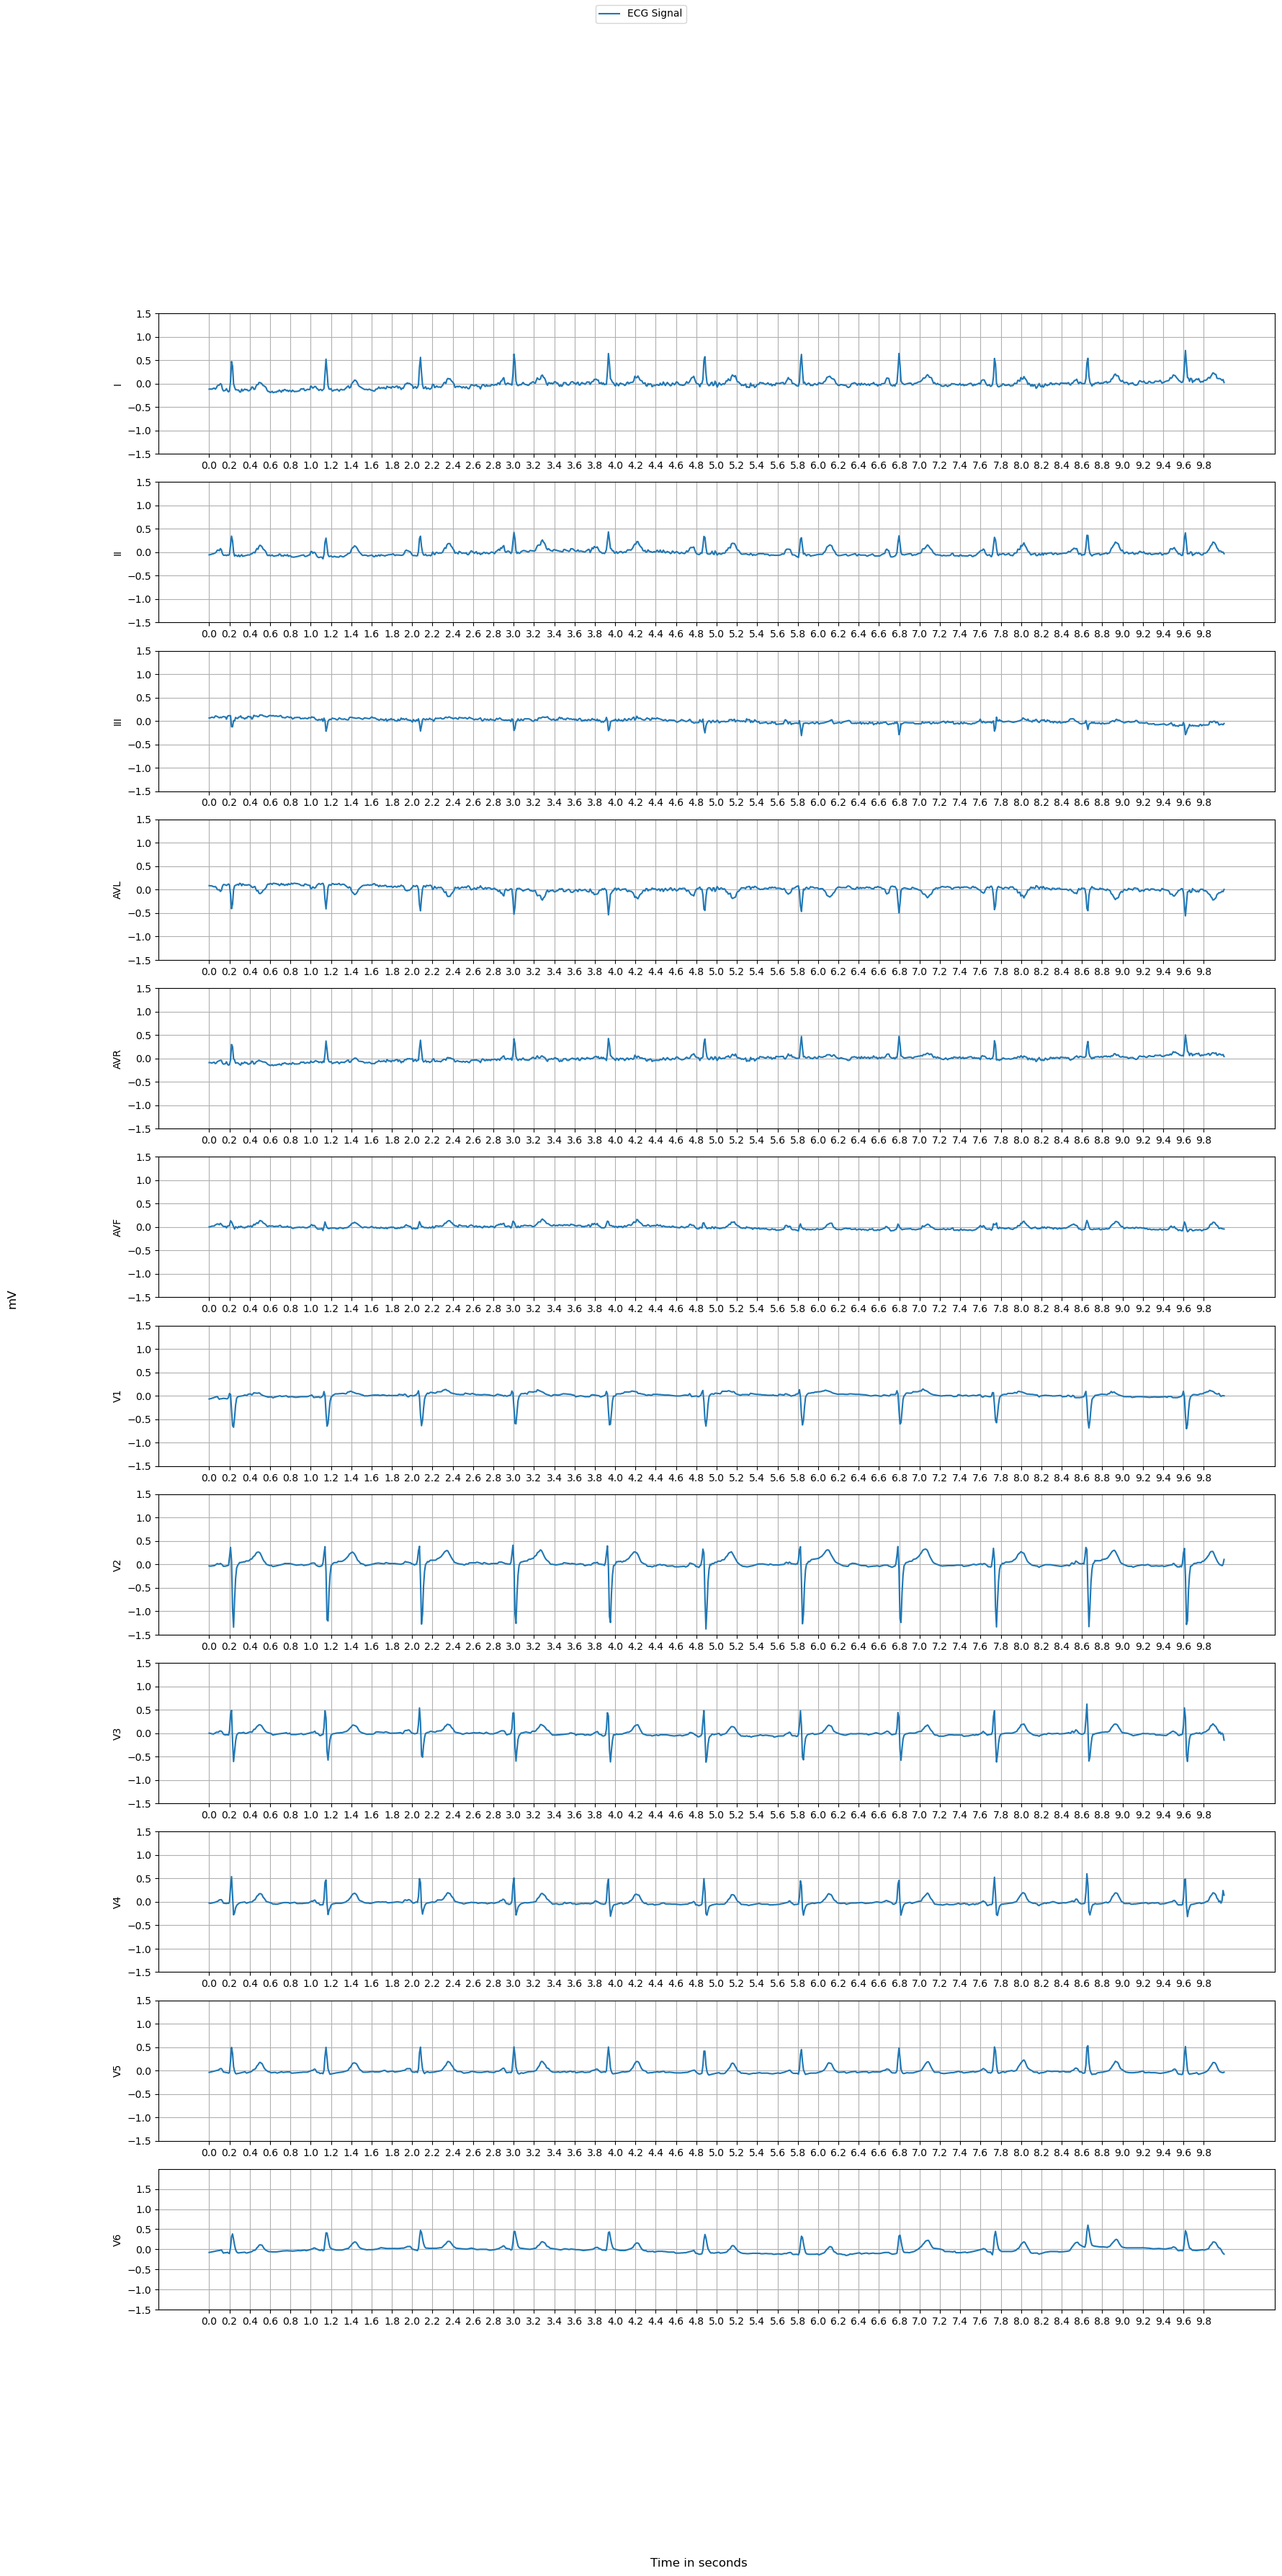

In [4]:
patient_id = 0
plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate)

# Preprocessing
There are several ways to preprocess the signal. Here we make sure to remove the baseline drift (shift of the baseline signal up or down) and high frequency noise.

Apply bandpass filter
Smooth Signal
Normalize Signal
Preprocessed Signal Figure:


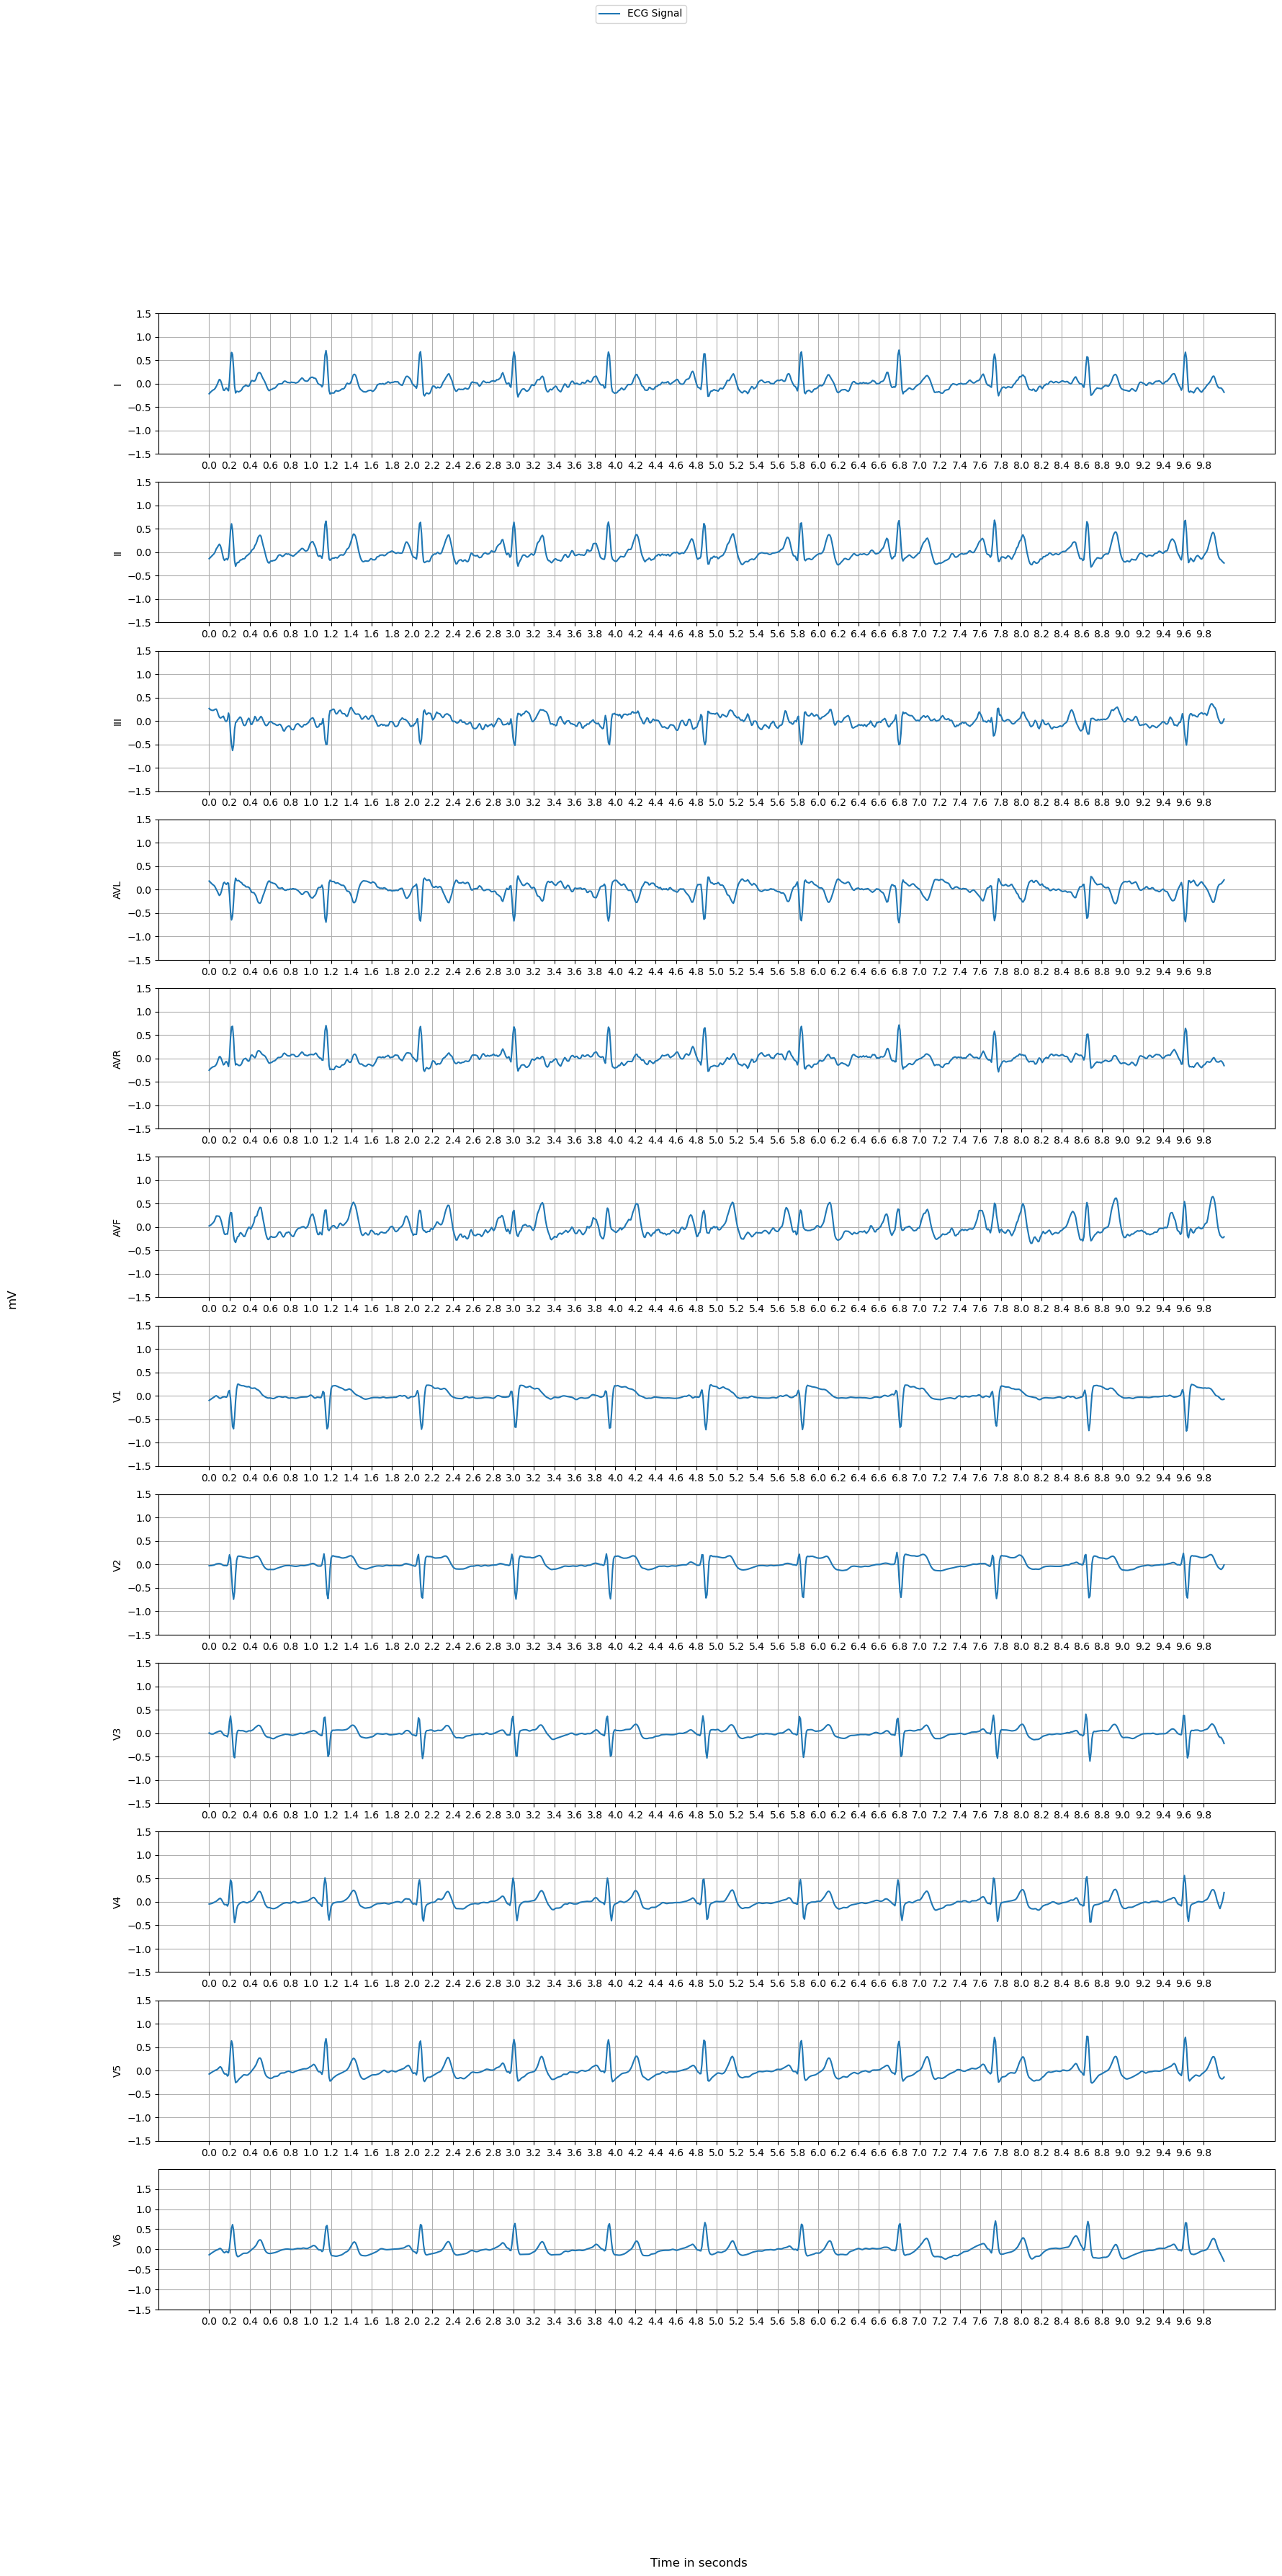

In [4]:
patient_id = 0
print('Apply bandpass filter')
X_preprocessed = butter_bandpass_filter(X, filter_freq=0.6, order=3)
print('Smooth Signal')
X_preprocessed = smooth_signal(X_preprocessed)
print('Normalize Signal')
X_preprocessed = normalize_signal(X_preprocessed)
print('Preprocessed Signal Figure:')
plot_ecg_signal(X_preprocessed[patient_id, :, :], channels=channels, sampling_rate=sampling_rate)


# Heart Beat Estimation
Some more information about the heart beat measurement with ECG can be found here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1122339/. <br>
In out code, we determine the heartbeat by the peaks in the normalized signal.
If there are peaks in multiple leads and in a realistic frequency, we assume to have actual heartbeat peaks. <br>
We mark the detected peaks by red triangles and the heartbeats by red vertical lines in the ECG.


Number of estimated heartbeats: 11
Average heart beat frequency: 66.0 beats/min


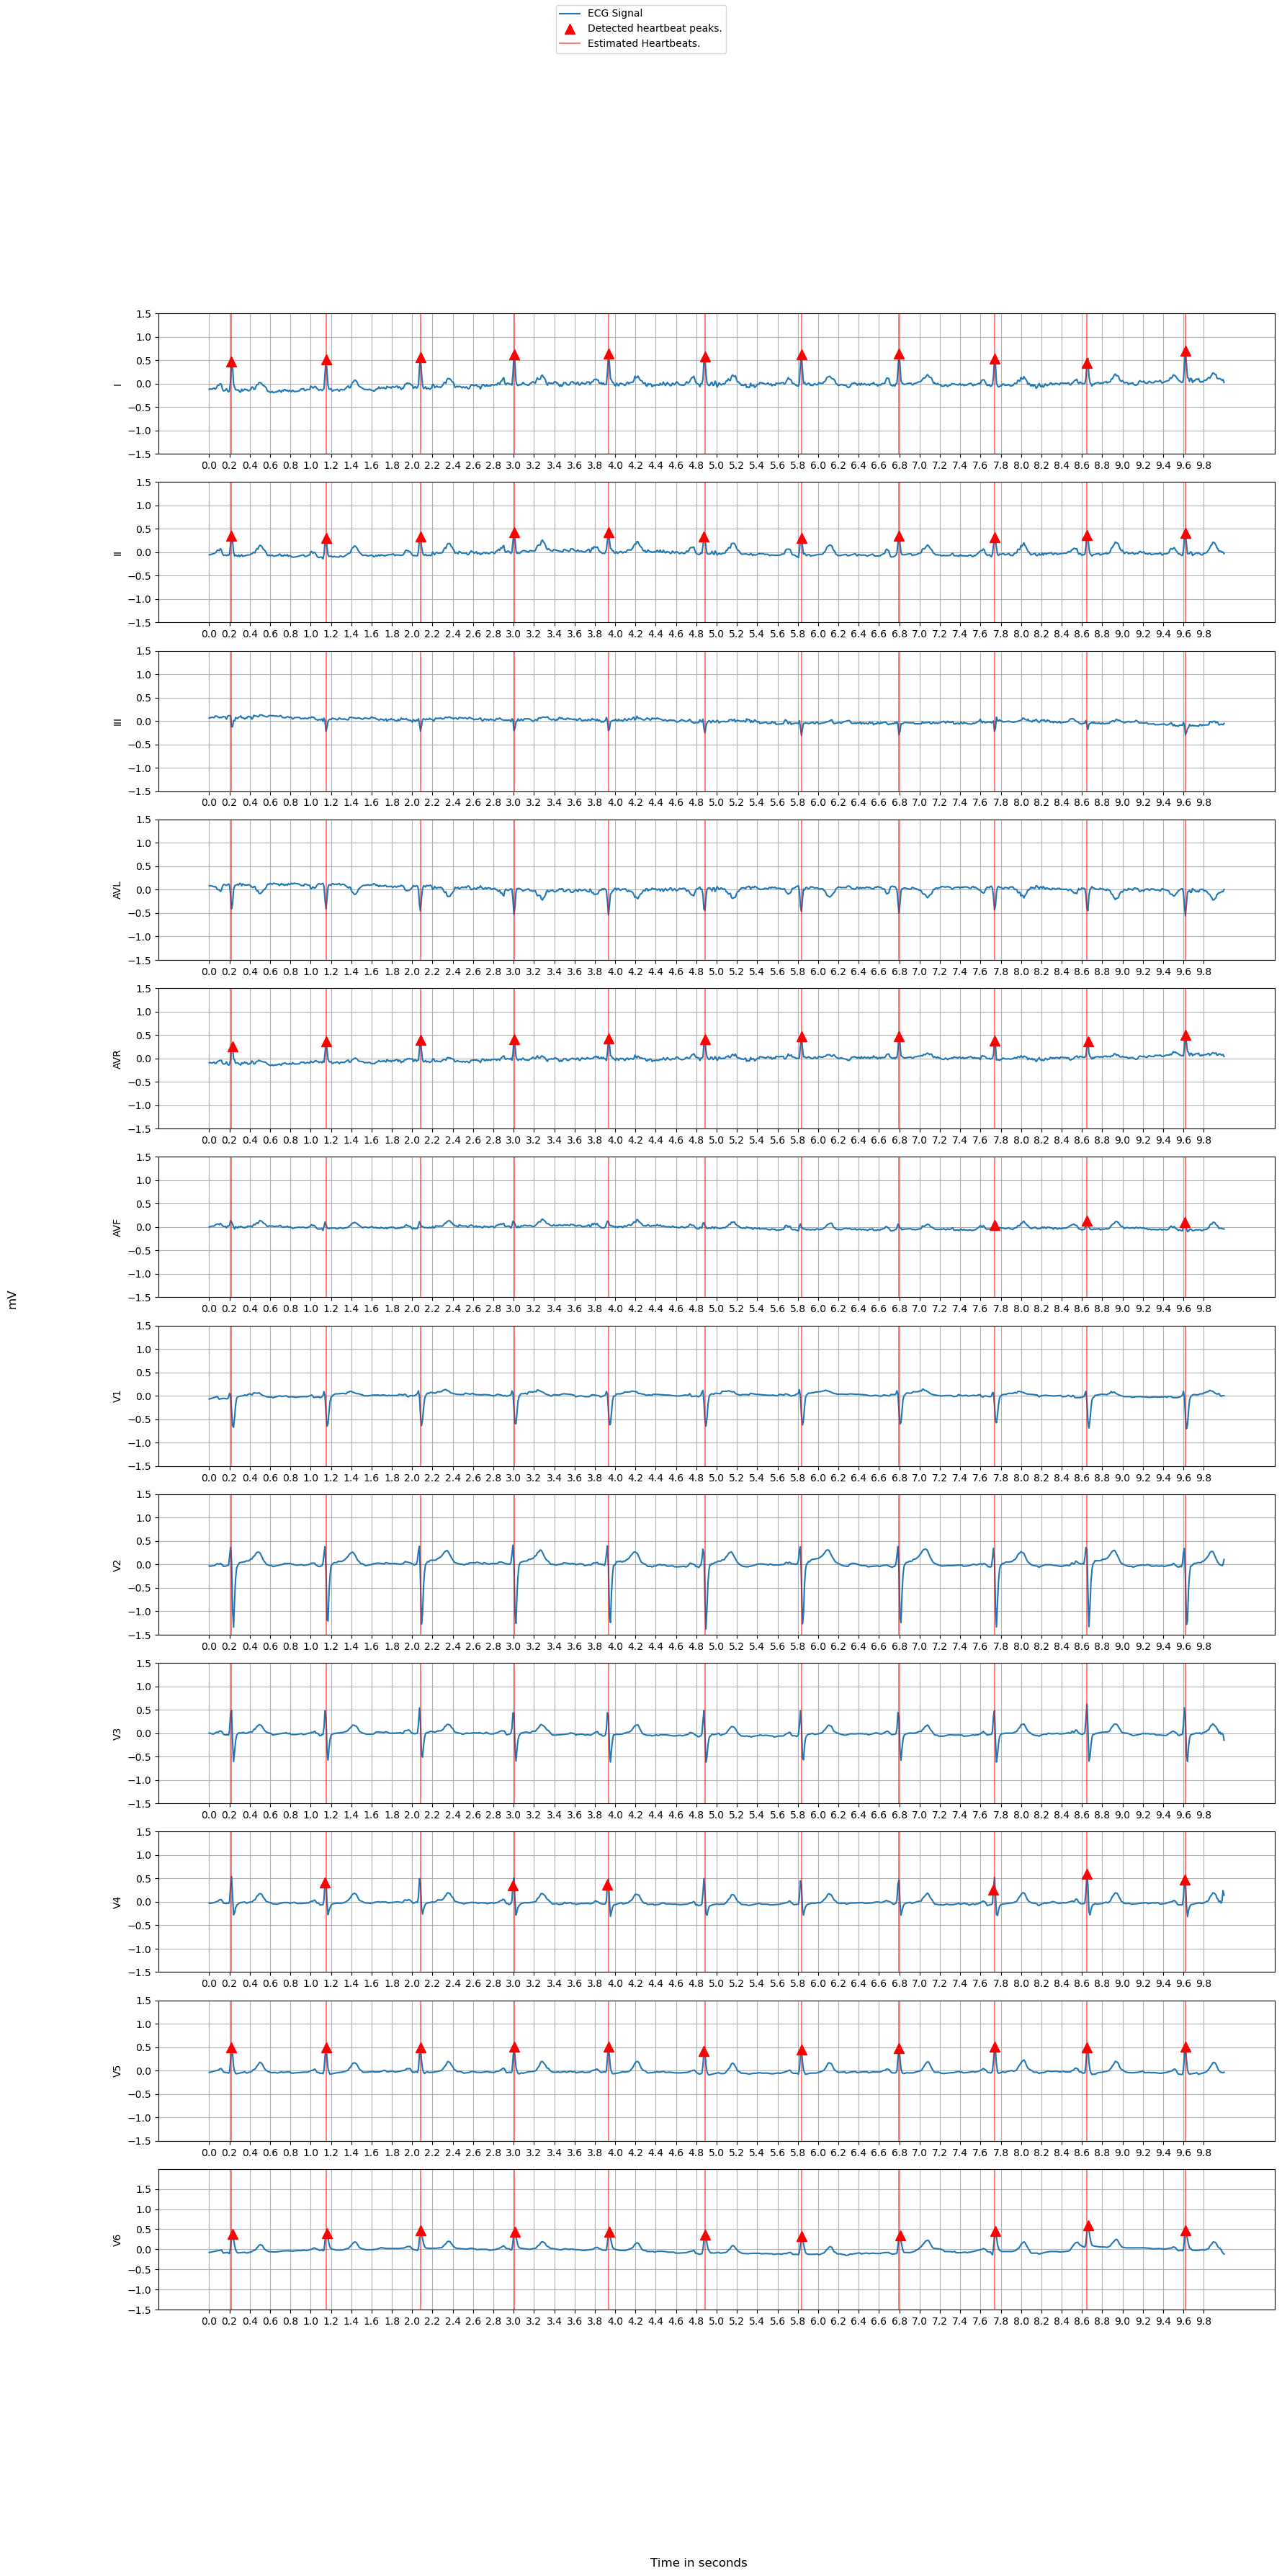

In [6]:
patient_id = 0
peaks = find_peaks(X_preprocessed[patient_id,:,:])
heartbeat, heartbeat_peaks = find_heartbeat_peaks(peaks)

failed_detection = False
if len(heartbeat) < 6:
    failed_detection = True

if not failed_detection:
    print('Number of estimated heartbeats: ' + str(len(heartbeat)))
    print('Average heart beat frequency: ' + str(60*len(heartbeat)/10) + ' beats/min')
    plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate, 
                    heartbeats=heartbeat, heartbeat_peaks=heartbeat_peaks)
else:
    print('Signal is not clear enough for automatic detection.')

## Mark QRS complex
Now we want to detect and highlight the QRS complex. 
More information can be found here: https://ecgwaves.com/ecg-qrs-complex-q-r-s-wave-duration-interval/
We use the detected heartbeat peaks ('R-wave') and the slopes to the left and right of it to find the QRS complex. The algorithm searches for a 'valley' on the left and right (Q and S wave) and the following plateau. <br>
The QRS complex is plotted in yellow.

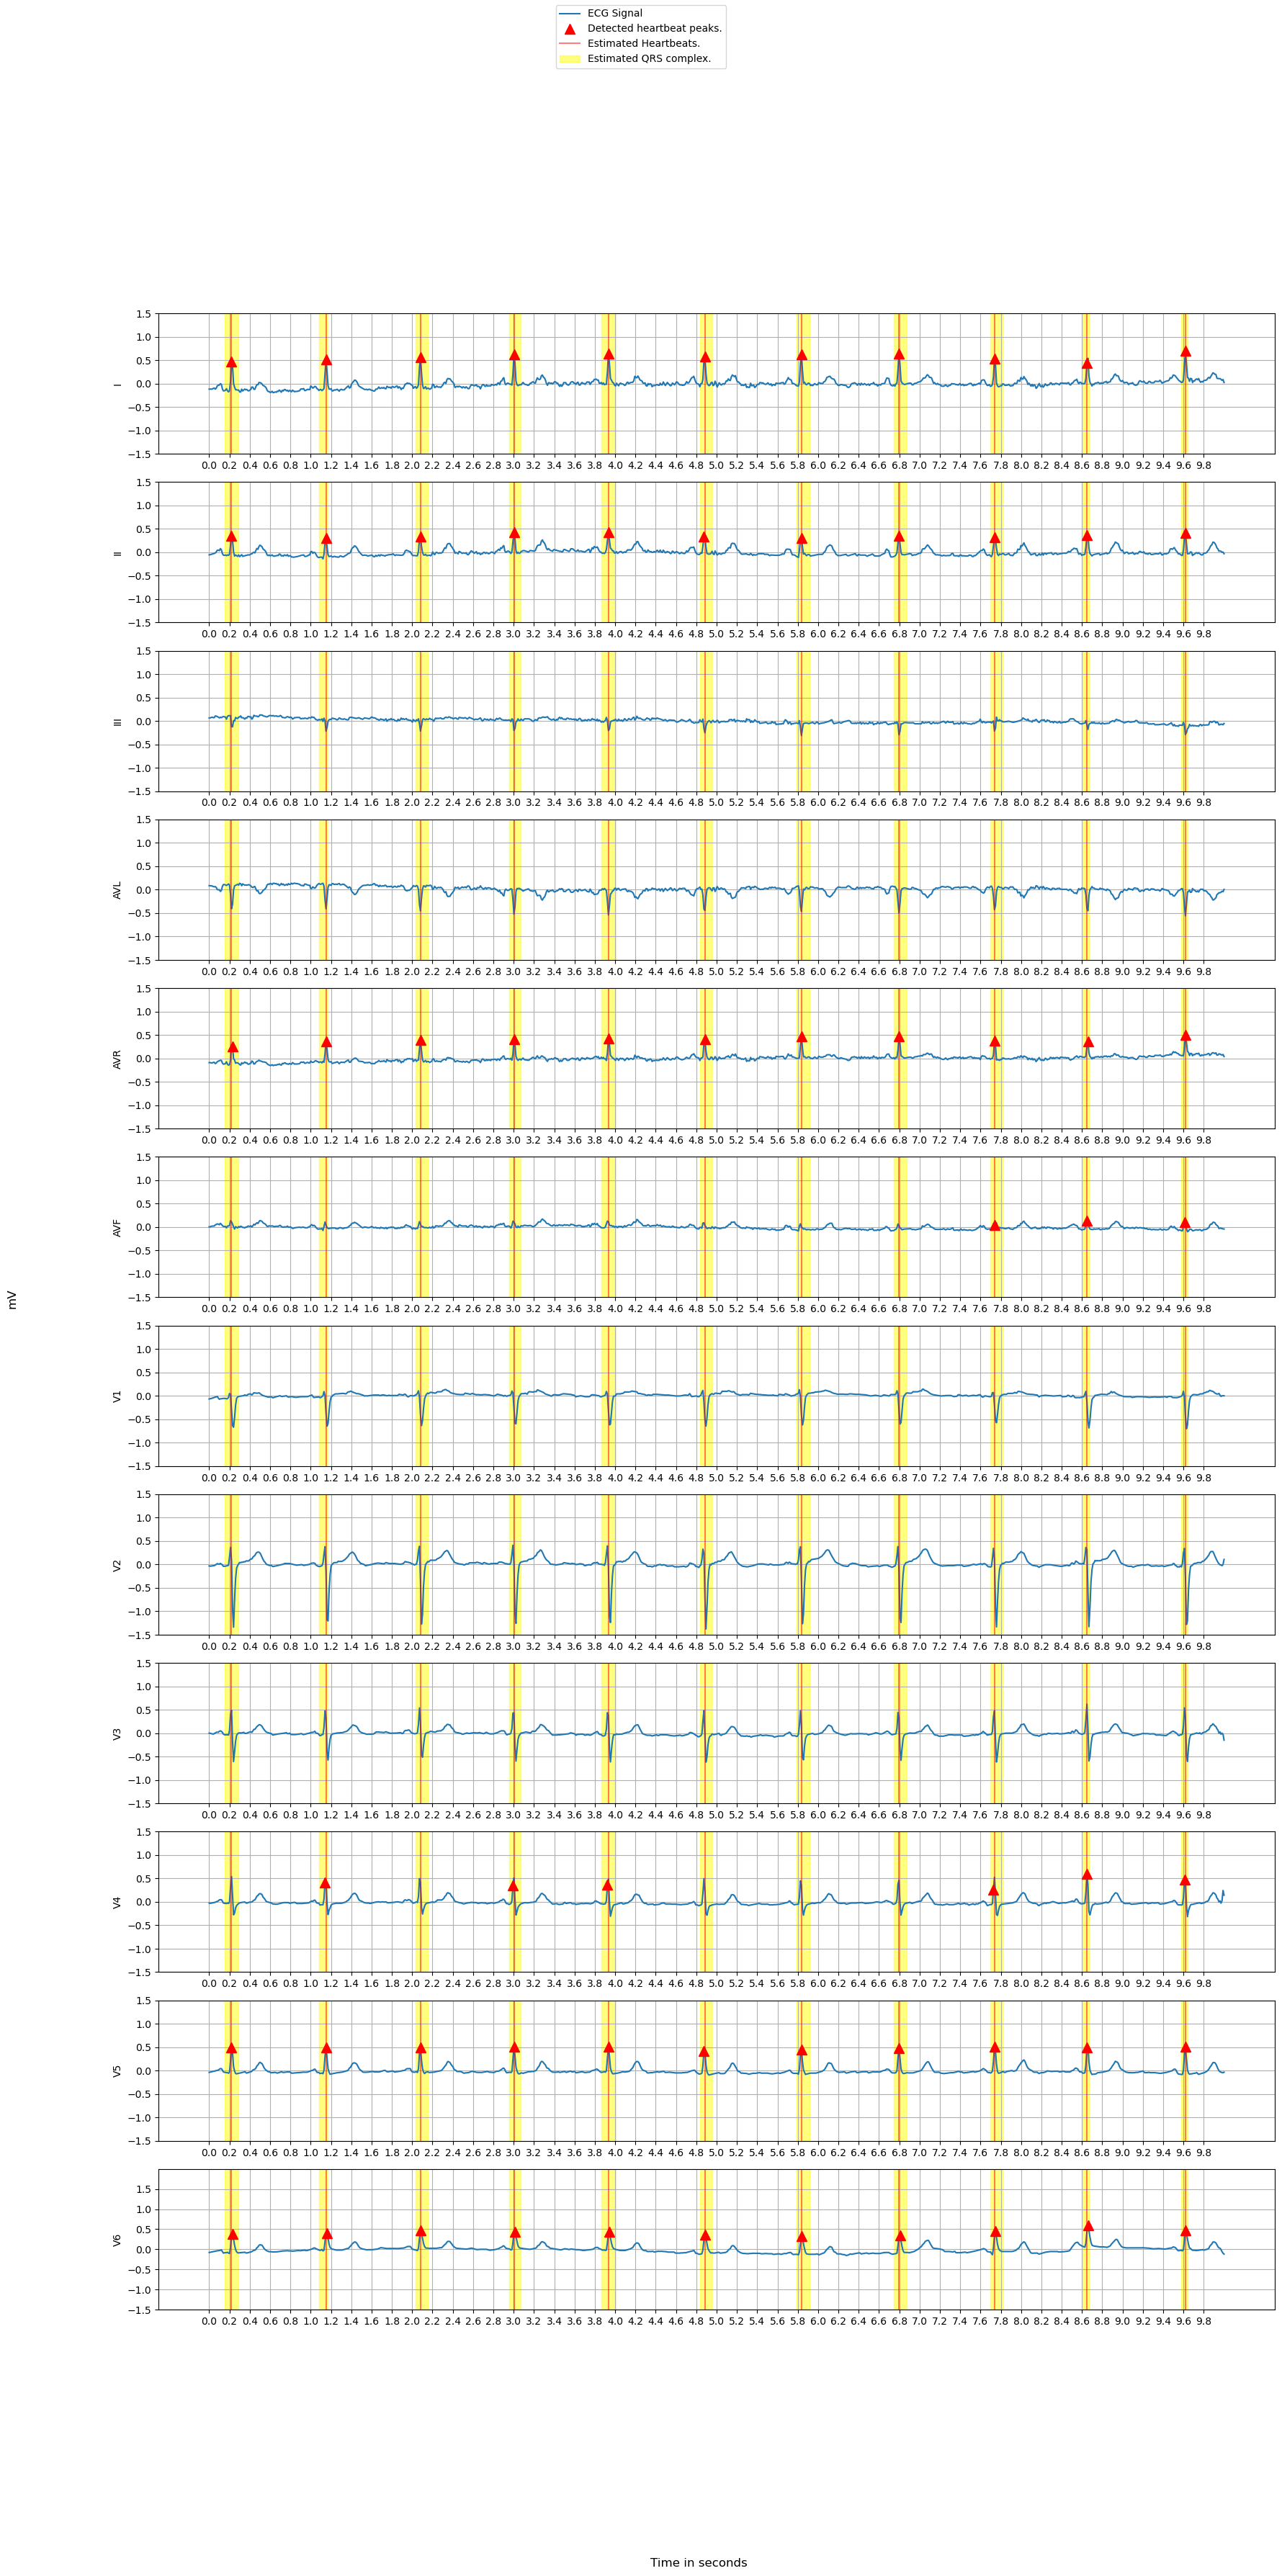

In [7]:
qrs_start_median, qrs_end_median = find_qrs_complex(X_preprocessed[patient_id,:,:], heartbeat, heartbeat_peaks)
plot_ecg_signal(X[patient_id, :, :], channels=channels, sampling_rate=sampling_rate, 
                heartbeats=heartbeat, heartbeat_peaks=heartbeat_peaks, qrs_intervals = (qrs_start_median, qrs_end_median))




### 

# Deep Learning Classification of ECG Signal
In the next step we want to classify the ECG data regarding the 5 given classes that are described in the dataset README:

Samples | Class <br>
9517	| NORM	Normal <br>
5473	| MI	Myocardial Infarction <br>
5237	| STTC	ST/T Change <br>
4901	| CD	Conduction Disturbance <br>
2649	| HYP	Hypertrophy <br>

We use a simple convolutional neural network. It uses one-dimensional convolutions over the signal in all 12 channels. To enable the model to process a larger part of the signal curve, we use a kernel size of 10 and a dilation of 2. This makes each convolution 'see' a range of 20 indices of the signal. <br>
The convolutional layers are followed by a dropout layer and three fully connected layers. <br>

There are some parameters of the model that can be manipulated in the config dict.



In [9]:
config = {'run_name': 'new_model_experiment',
          'model_name': 'tiny_model',
          'conv_layers': 2,
          'conv_kernels': 2,
          'learning_rate': 0.001,
          'epochs': 50}

model_handler = ModelHandler(X.shape[2], X.shape[1], 5, config)
train_generator, test_generator = get_cross_validation_split(X, Y, test_fold=1)
model_handler.train(train_generator)
results = model_handler.validate(test_generator, 'test')
print(results)

Epoch 0 Loss: 0.014061997
{'train_NORM_acc': 0.5629776826658515, 'train_NORM_recall': 0.0, 'train_NORM_precision': 1.0, 'train_MI_acc': 0.7491083256904106, 'train_STTC_acc': 0.759961275858555, 'train_CD_acc': 0.7747885458065831, 'train_HYP_acc': 0.8784265769897075}
Epoch 10 Loss: 0.10735965
{'train_NORM_acc': 0.5642515031081219, 'train_NORM_recall': 0.0030313629474175117, 'train_NORM_precision': 0.9629629629629629, 'train_MI_acc': 0.7507388158565169, 'train_STTC_acc': 0.774533781718129, 'train_CD_acc': 0.7749923570773464, 'train_HYP_acc': 0.8844390094772241}
Epoch 20 Loss: 0.0024502461
{'train_NORM_acc': 0.6143890757158871, 'train_NORM_recall': 0.12102133613151451, 'train_NORM_precision': 0.9728209934395501, 'train_MI_acc': 0.7962396820544176, 'train_STTC_acc': 0.8714460409660654, 'train_CD_acc': 0.7889024763069398, 'train_HYP_acc': 0.9101701824110874}
Epoch 30 Loss: 7.5487065e-09
{'train_NORM_acc': 0.7632732090084582, 'train_NORM_recall': 0.4670630756674828, 'train_NORM_precision': 0.

## Crossvalidation
In the dataset, there are 10 crossvalidation splits pre-defined. The crossvalidation experiments take a long time, so I do not recommend to execute it here. I have run all crossvalidation experiments in different settings and report the results below. Anyway, to train and test the model on all crossvalidation splits, you can use the following function:

In [ ]:
# mean_results = run_crossvalidation_experiment(X, Y, config)

## Results

To evaluate the performed runs, the tools MLflow is used (https://mlflow.org/).
It allows to track all parameters, metrics, git hashes, etc. and includes a UI.
If you have followed the INSTRUCTIONS.md you should be able to simply access 'http://127.0.0.1:5005' with your browser to see all runs. Else it might be necessary to run `mlflow ui -h 0.0.0.0 -p 5005`. In the interface you can see all performed runs with training and testing and the final crossvalidation metrics. <br> <br>

Three different model configurations were tested: <br>
small_model: 4 convolutional layers with 4 kernels <br>
medium_model: 6 convolutional layers with 6 kernels <br>
large_model: 8 convolutional layers with 8 kernels <br>

We left the learning rate (=0.001) and epochs (=100) the same for all experiments.

The best performing model was the small_model. Here a screenshot of the results as displayed in mlflow:

![Results](./experiments/results.png)



# Next Steps
If I would have more time, I would do the following:
* Write unit tests for the existing functions.
* Use train/validation/test splits to avoid overfitting with early stopping (currently only train/test).
* Try more model configurations.
* Implement model saving//loading and include the model in the mlflow logging.
* Tryout other network architectures like LSTMs or transformers.
* Implement algorithms of explainability to highlight signal parts that are import for the model decision.


# Lessons Learned
* The ECG looks easy to process on the first sight - but it is quite hard to process it with traditional pattern recognition methods as in this project to detect heartbeats and QRS complex. There can be a lot of noise in the signal and it is not easy to filter it without loosing information. 
* The heartbeat can be detected quite reliably with the signal. The QRS complex detection is already a harder task - here my algorithm fails sometimes, depending on the quality of the ECG signal for each patient.
* The difficulty of processing the signal with 'traditional' pattern recognition encourages to use deep learning methods. Instead of looking for complex rules (like the peaks and valleys in the signal), a deep learning model could segment the signal with probably better results.
* The prototype of the deep learning model developed in this project learns to classify with accuracies around 80%. This is not enough for clinical applications. But I am convinced that this result could be improved with more experiments with different model architectures and hyperparameters. The experiments showed, that 1-dimensional convolutional layers are able to extract meaningful information from the ECG signal.